In [37]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.linalg import pinv
from itertools import product
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import shutil
from typing import Tuple
import anndata
from anndata import AnnData
from scipy.io import mmread
import requests
import warnings
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap


In [2]:
"""
Download, read, and preprocess Mcfarland et al. (2020) expression data.

Single-cell expression data from Mcfarland et al. Multiplexed single-cell
transcriptional response profiling to define cancer vulnerabilities and therapeutic
mechanism of action. Nature Communications (2020).
"""


def download_binary_file(file_url: str, output_path: str) -> None:
    """
    Download binary data file from a URL.

    Args:
    ----
        file_url: URL where the file is hosted.
        output_path: Output path for the downloaded file.

    Returns
    -------
        None.
    """
    request = requests.get(file_url)
    with open(output_path, "wb") as f:
        f.write(request.content)
    print(f"Downloaded data from {file_url} at {output_path}")

    
    
def download_mcfarland_2020(output_path: str) -> None:
    """
    Download Mcfarland et al. 2020 data from the hosting URLs.

    Args:
    ----
        output_path: Output path to store the downloaded and unzipped
        directories.

    Returns
    -------
        None. File directories are downloaded and unzipped in output_path.
    """
    idasanutlin_url = "https://figshare.com/ndownloader/files/18716351"
    idasanutlin_output_filename = os.path.join(output_path, "idasanutlin.zip")

    download_binary_file(idasanutlin_url, idasanutlin_output_filename)
    idasanutlin_output_dir = idasanutlin_output_filename.replace(".zip", "")
    shutil.unpack_archive(idasanutlin_output_filename, idasanutlin_output_dir)

    dmso_url = "https://figshare.com/ndownloader/files/18716354"
    dmso_output_filename = os.path.join(output_path, "dmso.zip")

    download_binary_file(dmso_url, dmso_output_filename)
    dmso_output_dir = dmso_output_filename.replace(".zip", "")
    shutil.unpack_archive(dmso_output_filename, dmso_output_dir)


def _read_mixseq_df(directory: str) -> pd.DataFrame:
    data = mmread(os.path.join(directory, "matrix.mtx"))
    barcodes = pd.read_table(os.path.join(directory, "barcodes.tsv"), header=None)
    classifications = pd.read_csv(os.path.join(directory, "classifications.csv"))
    classifications["cell_line"] = np.array(
        [x.split("_")[0] for x in classifications.singlet_ID.values]
    )
    gene_names = pd.read_table(os.path.join(directory, "genes.tsv"), header=None)

    df = pd.DataFrame(
        data.toarray(),
        columns=barcodes.iloc[:, 0].values,
        index=gene_names.iloc[:, 0].values,
    )
    return df


def _get_tp53_mutation_status(directory: str) -> np.array:
    # Taken from https://cancerdatascience.org/blog/posts/mix-seq/
    TP53_WT = [
        "LNCAPCLONEFGC_PROSTATE",
        "DKMG_CENTRAL_NERVOUS_SYSTEM",
        "NCIH226_LUNG",
        "RCC10RGB_KIDNEY",
        "SNU1079_BILIARY_TRACT",
        "CCFSTTG1_CENTRAL_NERVOUS_SYSTEM",
        "COV434_OVARY",
    ]

    classifications = pd.read_csv(os.path.join(directory, "classifications.csv"))
    TP53_mutation_status = [
        "Wild Type" if x in TP53_WT else "Mutation"
        for x in classifications.singlet_ID.values
    ]
    return np.array(TP53_mutation_status)


def read_mcfarland_2020(file_directory: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read the expression data for Mcfarland et al. 2020 in the given directory.

    Args:
    ----
        file_directory: Directory containing Mcfarland et al. 2020 data.

    Returns
    -------
        Two data frames of raw count expression data. The first contains
        single-cell gene expression count data from cancer cell lines exposed to
        idasanutlin with cell identification barcodes as column names and gene IDs as
        indices. The second contains count data with the same format from samples
        exposed to a control solution (DMSO).
    """
    idasanutlin_dir = os.path.join(
        file_directory, "idasanutlin", "Idasanutlin_24hr_expt1"
    )
    idasanutlin_df = _read_mixseq_df(idasanutlin_dir)

    dmso_dir = os.path.join(file_directory, "dmso", "DMSO_24hr_expt1")
    dmso_df = _read_mixseq_df(dmso_dir)

    return idasanutlin_df, dmso_df


def preprocess_mcfarland_2020(download_path: str, n_top_genes: int) -> AnnData:
    """
    Preprocess expression data from Mcfarland et al., 2020.

    Args:
    ----
        download_path: Path containing the downloaded Mcfarland et al. 2020 data files.
        n_top_genes: Number of most variable genes to retain.

    Returns
    -------
        An AnnData object containing single-cell expression data. The layer
        "count" contains the count data for the most variable genes. The X
        variable contains the total-count-normalized and log-transformed data
        for the most variable genes (a copy with all the genes is stored in
        .raw).
    """

    idasanutlin_df, dmso_df = read_mcfarland_2020(download_path)
    idasanutlin_df, dmso_df = idasanutlin_df.transpose(), dmso_df.transpose()

    m, n = idasanutlin_df.shape
    p, k = dmso_df.shape


    idasanutlin_adata = AnnData(idasanutlin_df)
    idasanutlin_dir = os.path.join(
        download_path, "idasanutlin", "Idasanutlin_24hr_expt1",
    )
    idasanutlin_adata.obs["TP53_mutation_status"] = _get_tp53_mutation_status(
        idasanutlin_dir
    )
    idasanutlin_adata.obs["condition"] = np.repeat(
        "Idasanutlin", idasanutlin_adata.shape[0]
    )

    dmso_adata = AnnData(dmso_df)
    dmso_dir = os.path.join(download_path, "dmso", "DMSO_24hr_expt1")
    dmso_adata.obs["TP53_mutation_status"] = _get_tp53_mutation_status(dmso_dir)
    dmso_adata.obs["condition"] = np.repeat("DMSO", dmso_adata.shape[0])

    full_adata = anndata.concat([idasanutlin_adata, dmso_adata])
    full_adata.layers["count"] = full_adata.X.copy()
    sc.pp.normalize_total(full_adata)
    sc.pp.log1p(full_adata)
    full_adata.raw = full_adata
    sc.pp.highly_variable_genes(
        full_adata,
        flavor="seurat_v3",
        n_top_genes=n_top_genes,
        layer="count",
        subset=True,
    )
    full_adata = full_adata[
        full_adata.layers["count"].sum(1) != 0
    ]  # Remove cells with all zeros.

    full_data = full_adata.to_df()

    return full_adata

In [6]:
root_data_path = '/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules'  # local computer data path to downloaad the dataset. 

data = preprocess_mcfarland_2020(root_data_path, 1000)

/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
foreground = data[:3096, ]
background = data[3097:, ]

labels = np.where(foreground.obs['TP53_mutation_status'] == 'Mutation', 1, 0)

foreground = foreground.to_df()
background = background.to_df()
foreground.head()

,ENSG00000188290,ENSG00000187608,ENSG00000178821,ENSG00000187730,ENSG00000157873,ENSG00000142606,ENSG00000234546,ENSG00000162444,ENSG00000116661,ENSG00000120937,...,ENSG00000184012,ENSG00000160180,ENSG00000160181,ENSG00000160182,ENSG00000160200,ENSG00000160213,ENSG00000224930,ENSG00000142156,ENSG00000142173,ENSG00000160307
AAACCTGAGATCCTGT-1,1.184084,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.184084,0.0,0.0,0.0,0.000000
AAACCTGAGGATGTAT-1,0.655526,1.198575,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.728248,0.0,0.0,0.0,0.000000
AAACCTGCAGAGCCAA-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,2.579365,0.0,0.0,0.0,2.579365
AAACCTGCAGCGTCCA-1,0.000000,0.000000,0.796392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,2.373994,0.0,0.0,0.0,0.000000
AAACCTGGTACCTACA-1,0.000000,0.914139,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.914139,2.136901,0.0,0.0,1.383605,0.0,0.0,0.0,0.000000


In [10]:
classifications_foreground = pd.read_csv("classifications_foreground.csv")
classifications_background = pd.read_csv("classifications_background.csv")


gene_names = foreground.columns.to_numpy()
cell_names = foreground.index.to_numpy()

In [11]:
foreground_barcodes = foreground.index.astype(str).str.strip()  
classifications_foreground['barcode'] = classifications_foreground['barcode'].astype(str).str.strip()  
merged_data = pd.merge(foreground_barcodes.to_frame(name='barcode'), classifications_foreground, left_on='barcode', right_on='barcode', how='left')
cell_types = merged_data['singlet_ID'].values

background_barcodes = background.index.astype(str).str.strip()  
classifications_background['barcode'] = classifications_background['barcode'].astype(str).str.strip()  
merged_data_background = pd.merge(background_barcodes.to_frame(name='barcode'), classifications_background, left_on='barcode', right_on='barcode', how='left')
cell_types_background = merged_data_background['singlet_ID'].values

In [12]:
X = foreground.to_numpy()
Y = background.to_numpy()

In [16]:
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur')
from main import*

In [18]:
c = 10
k = 7
cols_contrastive = ccur(X,Y,k,c)[0]
gene_names[cols_contrastive]

array(['ENSG00000186994', 'ENSG00000196734', 'ENSG00000183273',
       'ENSG00000240386', 'ENSG00000134545', 'ENSG00000175600',
       'ENSG00000135423', 'ENSG00000161513', 'ENSG00000148357',
       'ENSG00000095970'], dtype=object)

In [20]:
cols_foreground = deterministic_cur(X, k, c)[3]
gene_names[cols_foreground]

array(['ENSG00000196754', 'ENSG00000100097', 'ENSG00000125148',
       'ENSG00000108298', 'ENSG00000205542', 'ENSG00000197956',
       'ENSG00000111057', 'ENSG00000026025', 'ENSG00000124762',
       'ENSG00000198034'], dtype=object)

In [22]:
cols_union = deterministic_cur(np.concatenate((X,Y)), k, c)[3]
gene_names[cols_union]

array(['ENSG00000196754', 'ENSG00000100097', 'ENSG00000108298',
       'ENSG00000205542', 'ENSG00000125148', 'ENSG00000111057',
       'ENSG00000197956', 'ENSG00000026025', 'ENSG00000198034',
       'ENSG00000165949'], dtype=object)

In [24]:
alpha = 1

constrastive_cov = np.cov(X, rowvar = False) - alpha * np.cov(Y, rowvar = False)
eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)

first_pc = eigenvectors[:, np.argmax(eigenvalues)]  
cpca_indices = np.argsort(np.abs(first_pc))[-c:] 
gene_names[cpca_indices]  


array(['ENSG00000116717', 'ENSG00000197061', 'ENSG00000175600',
       'ENSG00000161513', 'ENSG00000108106', 'ENSG00000185088',
       'ENSG00000115129', 'ENSG00000135679', 'ENSG00000130513',
       'ENSG00000124762'], dtype=object)

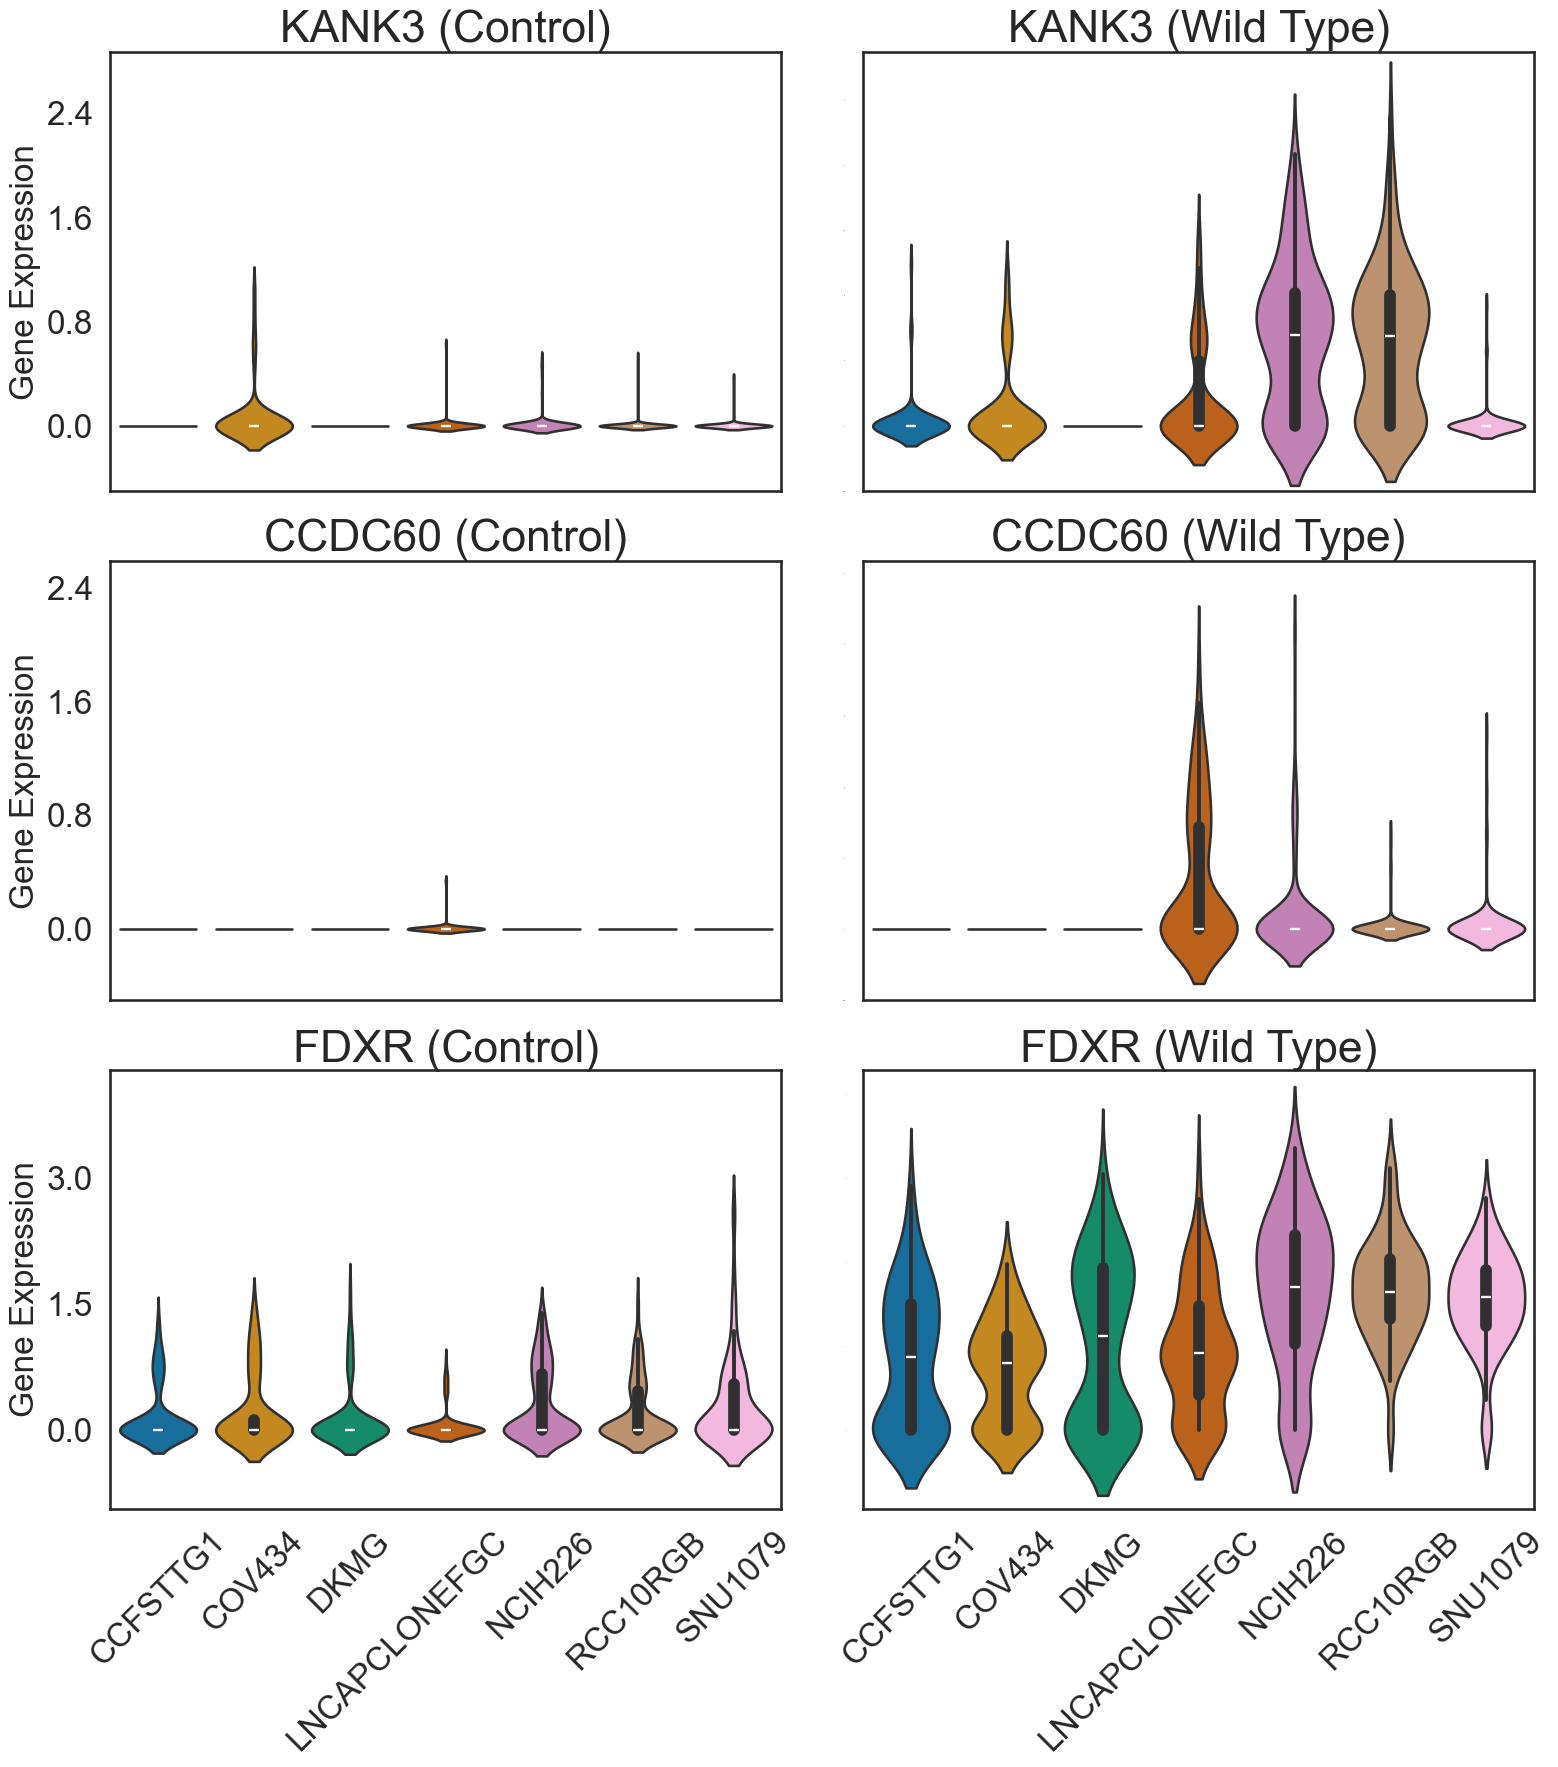

In [31]:
gene_indices = [cols_contrastive[0], cols_contrastive[2], cols_contrastive[7]]
gene_names = ["KANK3", "CCDC60", "FDXR"]

selected_cell_types = [
    'CCFSTTG1', 'COV434', 'DKMG',
    'LNCAPCLONEFGC', 'NCIH226',
    'RCC10RGB', 'SNU1079'
]

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'          
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values
cell_types_background_short = pd.Series(cell_types_background).map(cell_type_map).fillna(pd.Series(cell_types_background)).values

sns.set_theme(style="white", context="talk", palette="colorblind")
title_fontsize = 32
axis_label_fontsize = 24
tick_label_fontsize = 24
palette = sns.color_palette("colorblind", len(selected_cell_types))

fig, axes = plt.subplots(len(gene_indices), 2, figsize=(16, 6 * len(gene_indices)))
palette_dict = {cell_type: color for cell_type, color in zip(selected_cell_types, palette)}

for i, (gene_index, gene_name) in enumerate(zip(gene_indices, gene_names)):
    gene_expression_foreground = foreground.iloc[:, gene_index]
    gene_expression_background = background.iloc[:, gene_index]

    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground.values,
        'Cell Type': cell_types_short,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Cell Type': cell_types_background_short,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_foreground_filtered = data_foreground[data_foreground['Cell Type'].isin(selected_cell_types)]
    data_background_filtered = data_background[data_background['Cell Type'].isin(selected_cell_types)]

    data_mutation_0 = data_foreground_filtered[data_foreground_filtered['Group'] == 0]

    y_min = min(
        data_foreground_filtered['Gene Expression'].min(),
        data_background_filtered['Gene Expression'].min()
    ) - 0.5
    y_max = max(
        data_foreground_filtered['Gene Expression'].max(),
        data_background_filtered['Gene Expression'].max()
    ) + 0.5

    if i == 2:  
        buffer = 0.1 * (y_max - y_min)  
        y_min -= buffer  
        y_max += buffer  

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background_filtered,
        order=selected_cell_types, ax=axes[i, 0], hue='Cell Type', legend=False, palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=title_fontsize)
    axes[i, 0].set_ylim(y_min, y_max)  
    axes[i, 0].tick_params(axis='x', labelsize=0)  
    axes[i, 0].tick_params(axis='y', labelsize=tick_label_fontsize)

    axes[i, 0].set_ylabel("Gene Expression", fontsize=axis_label_fontsize)

    axes[i, 0].yaxis.set_major_locator(MaxNLocator(5))  

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_mutation_0,
        order=selected_cell_types, ax=axes[i, 1], hue='Cell Type', legend=False, palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Wild Type)", fontsize=title_fontsize)
    axes[i, 1].set_ylim(y_min, y_max)  
    axes[i, 1].tick_params(axis='x', labelsize=0)  
    axes[i, 1].tick_params(axis='y', labelsize=0)  

    if len(selected_cell_types) > 3 and i == 2:  
        for col in range(2):
            tick_labels = axes[i, col].get_xticklabels()
            fourth_label = tick_labels[3]
            axes[i, col].text(
                2.5, y_min - 0.2, fourth_label.get_text(),
                fontsize=tick_label_fontsize, ha='center', va='top', rotation=45
            )
            fourth_label.set_visible(False)

for ax in axes[:-1, :]:  
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])

for ax in axes[-1, :]: 
    ax.set_xticks(range(len(selected_cell_types)))  
    ax.set_xticklabels(selected_cell_types, rotation=45, fontsize=tick_label_fontsize)  

for ax in axes[:, 1]:  
    ax.set_ylabel('')  

for ax in axes.flatten():
    ax.set_xlabel('')  

plt.tight_layout()
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules')
#plt.savefig('sm_combined.png', dpi=300, bbox_inches='tight')
plt.show()


In [33]:
r = 100
k = 7
contrastive_indices = deterministic_cur(X[:,cols_contrastive],k,r)[4]
foreground_indices = deterministic_cur(X,k, r)[4]

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


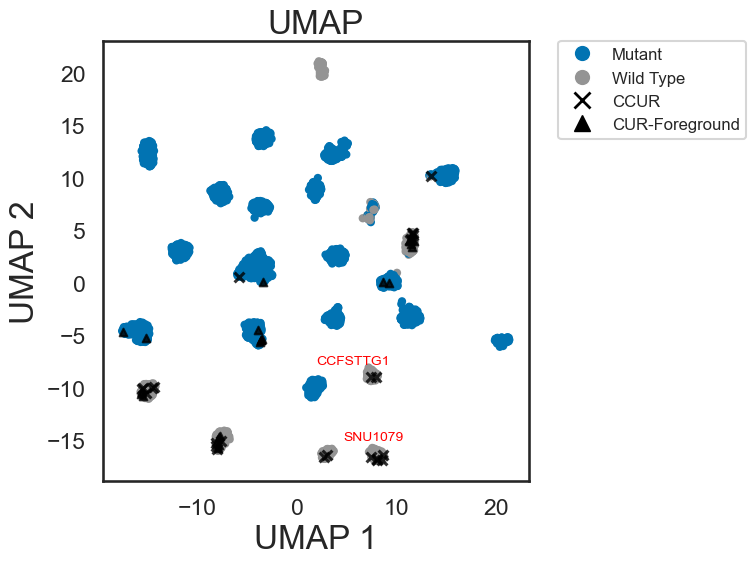

In [39]:
cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values

adata = sc.AnnData(foreground.values)
adata.obs['barcode'] = foreground.index 
adata.var['gene_name'] = foreground.columns 

adata.obs['cell_types'] = pd.Categorical(cell_types_short)  

selected_cell_types = ['CCFSTTG1', 'COV434', 'DKMG', 'LNCAPCLONEFGC', 'NCIH226', 'RCC10RGB', 'SNU1079']
adata.obs['Group'] = adata.obs['cell_types'].apply(
    lambda x: 'Wild Type' if x in selected_cell_types else 'Mutant'
)

adata.obs['Group'] = pd.Categorical(adata.obs['Group'])

sc.pp.neighbors(adata, n_neighbors=30) 
sc.tl.umap(adata)

coords = adata.obsm['X_umap']
groups = adata.obs['Group']

colorblind_palette = sns.color_palette("colorblind")
colors = [colorblind_palette[0], colorblind_palette[7]]  

palette = ListedColormap(colors)

def sample_indices_per_cell_type(indices, cell_types, max_markers=5):
    sampled_indices = []
    for cell_type in cell_types.cat.categories: 
        cell_type_indices = [
            idx for idx in indices
            if adata.obs.iloc[idx]['cell_types'] == cell_type  
        ]
        if len(cell_type_indices) > 0:
            sampled_indices.extend(
                np.random.choice(cell_type_indices, size=min(len(cell_type_indices), max_markers), replace=False)
            )
    return sampled_indices

contrastive_indices_capped = sample_indices_per_cell_type(contrastive_indices, adata.obs['cell_types'])

foreground_indices_capped = sample_indices_per_cell_type(foreground_indices, adata.obs['cell_types'])

plt.figure(figsize=(8, 6))  
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=groups.cat.codes, cmap=palette, s=20, alpha=1)

plt.scatter(coords[contrastive_indices_capped, 0], coords[contrastive_indices_capped, 1], 
            color='black', marker='x', s=50, label='Contrastive', alpha=0.8)

plt.scatter(coords[foreground_indices_capped, 0], coords[foreground_indices_capped, 1], 
            color='black', marker='^', s=30, label='CUR-Foreground', alpha=0.8)

highlighted_cell_types = ['SNU1079', 'CCFSTTG1', 'DKMG']
labeled_cell_types = set()  

for cell_type in highlighted_cell_types:
    indices = adata.obs.index[adata.obs['cell_types'] == cell_type]
    cell_coords = coords[[int(idx) for idx in indices], :]
    
    if cell_type == 'DKMG':
        target_x_range = (6, 10)
        target_y_range = (-20, -16)
        second_dkmg_coords = cell_coords[
            (cell_coords[:, 0] >= target_x_range[0]) & (cell_coords[:, 0] <= target_x_range[1]) &
            (cell_coords[:, 1] >= target_y_range[0]) & (cell_coords[:, 1] <= target_y_range[1])
        ]
        for x, y in second_dkmg_coords:
            plt.text(x, y + 1.9, 'DKMG', fontsize=10, color='red', ha='center', va='center')  
            break  

    elif cell_type == 'CCFSTTG1' and cell_type not in labeled_cell_types:
        for x, y in cell_coords:
            plt.text(x - 1.5, y + 1.3, cell_type, fontsize=10, color='red', ha='center', va='center')
            labeled_cell_types.add(cell_type)
            break  

    elif cell_type not in labeled_cell_types:
        for x, y in cell_coords:
            plt.text(x, y + 1.3, cell_type, fontsize=10, color='red', ha='center', va='center')
            labeled_cell_types.add(cell_type)
            break  

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='w', markerfacecolor=colors[0],
               markersize=12, label='Mutant'),
    plt.Line2D([0], [0], marker='o', linestyle='None', color='w', markerfacecolor=colors[1],
               markersize=12, label='Wild Type'),
    plt.Line2D([0], [0], marker='x', linestyle='None', color='black', markersize=12, markeredgewidth = 2, label='CCUR'),
    plt.Line2D([0], [0], marker='^', linestyle='None', color='black', markersize=12, label='CUR-Foreground')  # Orange triangle
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 0.89), loc='center left', fontsize=12)

plt.title("UMAP", fontsize=24)
plt.xlabel("UMAP 1", fontsize=24)
plt.ylabel("UMAP 2", fontsize=24)

plt.tight_layout()
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules')
#plt.savefig('sm_rows.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
cell_type_assignments = adata.obs['cell_types']

contrastive_type_counts = cell_type_assignments[contrastive_indices].value_counts()
foreground_type_counts = cell_type_assignments[foreground_indices].value_counts()
true_type_counts = adata.obs['cell_types'].value_counts()

total_contrastive = len(contrastive_indices)
total_foreground = len(foreground_indices)

contrastive_proportions = contrastive_type_counts / total_contrastive
foreground_proportions = foreground_type_counts / total_foreground
total_cells = len(adata)
true_type_proportions = true_type_counts / total_cells

proportions_df = pd.DataFrame({
    'CCUR': contrastive_proportions,
    'CUR': foreground_proportions
})
proportions_df['True Proportion'] = true_type_proportions

proportions_df = proportions_df[(proportions_df > 0).any(axis=1)]
print(proportions_df)

                                  CCUR   CUR  True Proportion
cell_types                                                   
BICR31_UPPER_AERODIGESTIVE_TRACT  0.01  0.01         0.089470
BICR6_UPPER_AERODIGESTIVE_TRACT   0.00  0.00         0.035853
BT474_BREAST                      0.00  0.00         0.022933
BT549_BREAST                      0.00  0.00         0.042313
CAOV3_OVARY                       0.00  0.00         0.045220
CCFSTTG1                          0.02  0.00         0.024871
COLO680N_OESOPHAGUS               0.00  0.00         0.041667
COV434                            0.00  0.00         0.024225
DKMG                              0.02  0.00         0.030039
IALM_LUNG                         0.00  0.00         0.045543
LNCAPCLONEFGC                     0.18  0.53         0.036499
LS1034_LARGE_INTESTINE            0.00  0.02         0.037791
NCIH226                           0.36  0.03         0.030362
NCIH2347_LUNG                     0.00  0.00         0.051357
RCC10RGB

/var/folders/8z/wrr8y5fn609_d770khfs09mw0000gn/T/ipykernel_2747/3990537304.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contrastive_type_counts = cell_type_assignments[contrastive_indices].value_counts()
/var/folders/8z/wrr8y5fn609_d770khfs09mw0000gn/T/ipykernel_2747/3990537304.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  foreground_type_counts = cell_type_assignments[foreground_indices].value_counts()


## Supplementary

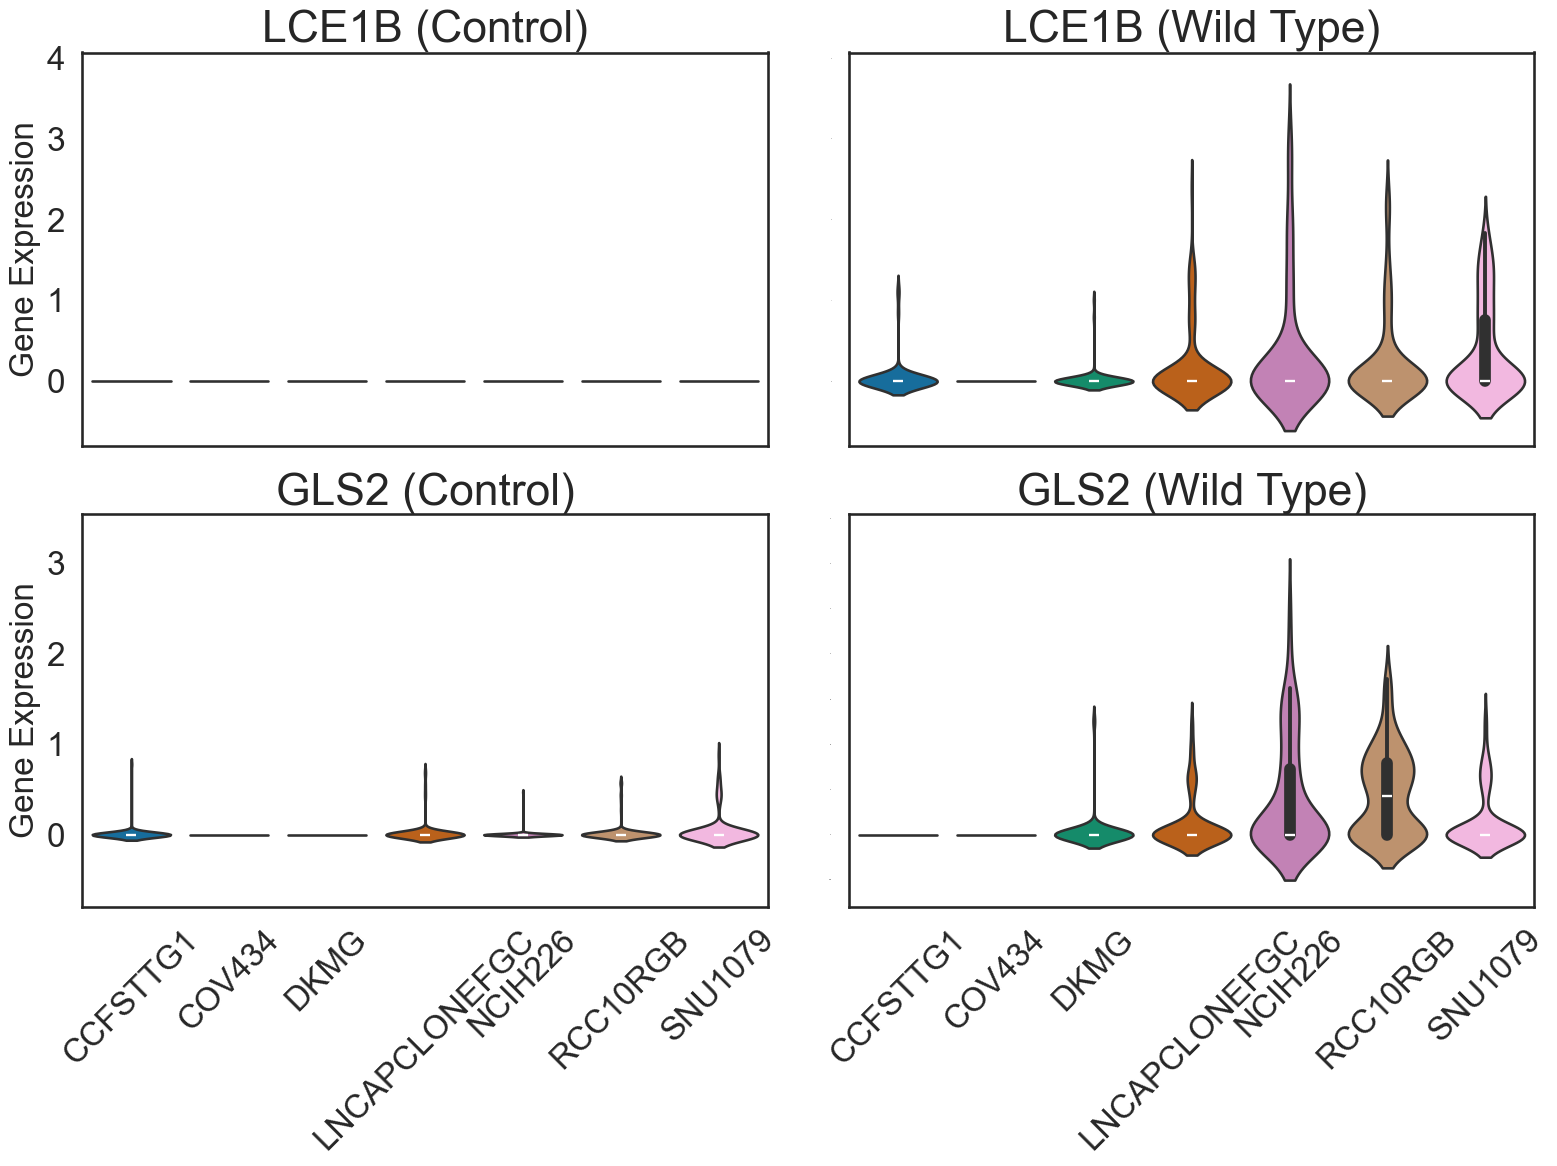

In [47]:
gene_indices = [cols_contrastive[1], cols_contrastive[6]]
gene_names = ["LCE1B", "GLS2"]

selected_cell_types = [
    'CCFSTTG1', 'COV434', 'DKMG',
    'LNCAPCLONEFGC', 'NCIH226',
    'RCC10RGB', 'SNU1079'
]

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'          
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values
cell_types_background_short = pd.Series(cell_types_background).map(cell_type_map).fillna(pd.Series(cell_types_background)).values

sns.set_theme(style="white", context="talk", palette="colorblind")
title_fontsize = 32
axis_label_fontsize = 24
tick_label_fontsize = 24
palette = sns.color_palette("colorblind", len(selected_cell_types))

fig, axes = plt.subplots(len(gene_indices), 2, figsize=(16, 6 * len(gene_indices)))
palette_dict = {cell_type: color for cell_type, color in zip(selected_cell_types, palette)}

for i, (gene_index, gene_name) in enumerate(zip(gene_indices, gene_names)):
    gene_expression_foreground = foreground.iloc[:, gene_index]
    gene_expression_background = background.iloc[:, gene_index]

    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground.values,
        'Cell Type': cell_types_short,
        'Group': labels  
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Cell Type': cell_types_background_short,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_foreground_filtered = data_foreground[data_foreground['Cell Type'].isin(selected_cell_types)]
    data_background_filtered = data_background[data_background['Cell Type'].isin(selected_cell_types)]

    data_mutation_0 = data_foreground_filtered[data_foreground_filtered['Group'] == 0]

    y_min = min(
        data_foreground_filtered['Gene Expression'].min(),
        data_background_filtered['Gene Expression'].min()
    ) - 0.8
    y_max = max(
        data_foreground_filtered['Gene Expression'].max(),
        data_background_filtered['Gene Expression'].max()
    ) + 1


    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background_filtered,
        order=selected_cell_types, ax=axes[i, 0], hue='Cell Type', legend=False, palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=title_fontsize)
    axes[i, 0].set_ylim(y_min, y_max)  
    axes[i, 0].tick_params(axis='x', labelsize=0)  
    axes[i, 0].tick_params(axis='y', labelsize=tick_label_fontsize)

    axes[i, 0].set_ylabel("Gene Expression", fontsize=axis_label_fontsize)

    axes[i, 0].yaxis.set_major_locator(MaxNLocator(5))  

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_mutation_0,
        order=selected_cell_types, ax=axes[i, 1], hue='Cell Type', legend=False, palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Wild Type)", fontsize=title_fontsize)
    axes[i, 1].set_ylim(y_min, y_max)  
    axes[i, 1].tick_params(axis='x', labelsize=0)  
    axes[i, 1].tick_params(axis='y', labelsize=0) 

    if len(selected_cell_types) > 3 and i == 2:  
        for col in range(2):
            tick_labels = axes[i, col].get_xticklabels()
            fourth_label = tick_labels[3]
            axes[i, col].text(
                2.5, y_min - 0.2, fourth_label.get_text(),
                fontsize=tick_label_fontsize, ha='center', va='top', rotation=45
            )
            fourth_label.set_visible(False)

for ax in axes[:-1, :]:  
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])

for ax in axes[-1, :]:  
    ax.set_xticks(range(len(selected_cell_types))) 
    ax.set_xticklabels(selected_cell_types, rotation=45, fontsize=tick_label_fontsize)  

for ax in axes[:, 1]: 
    ax.set_ylabel('')  

for ax in axes.flatten():
    ax.set_xlabel('')  

plt.tight_layout()
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules')
#plt.savefig('sm_ccur_suppl.png', dpi=300, bbox_inches='tight')
plt.show()



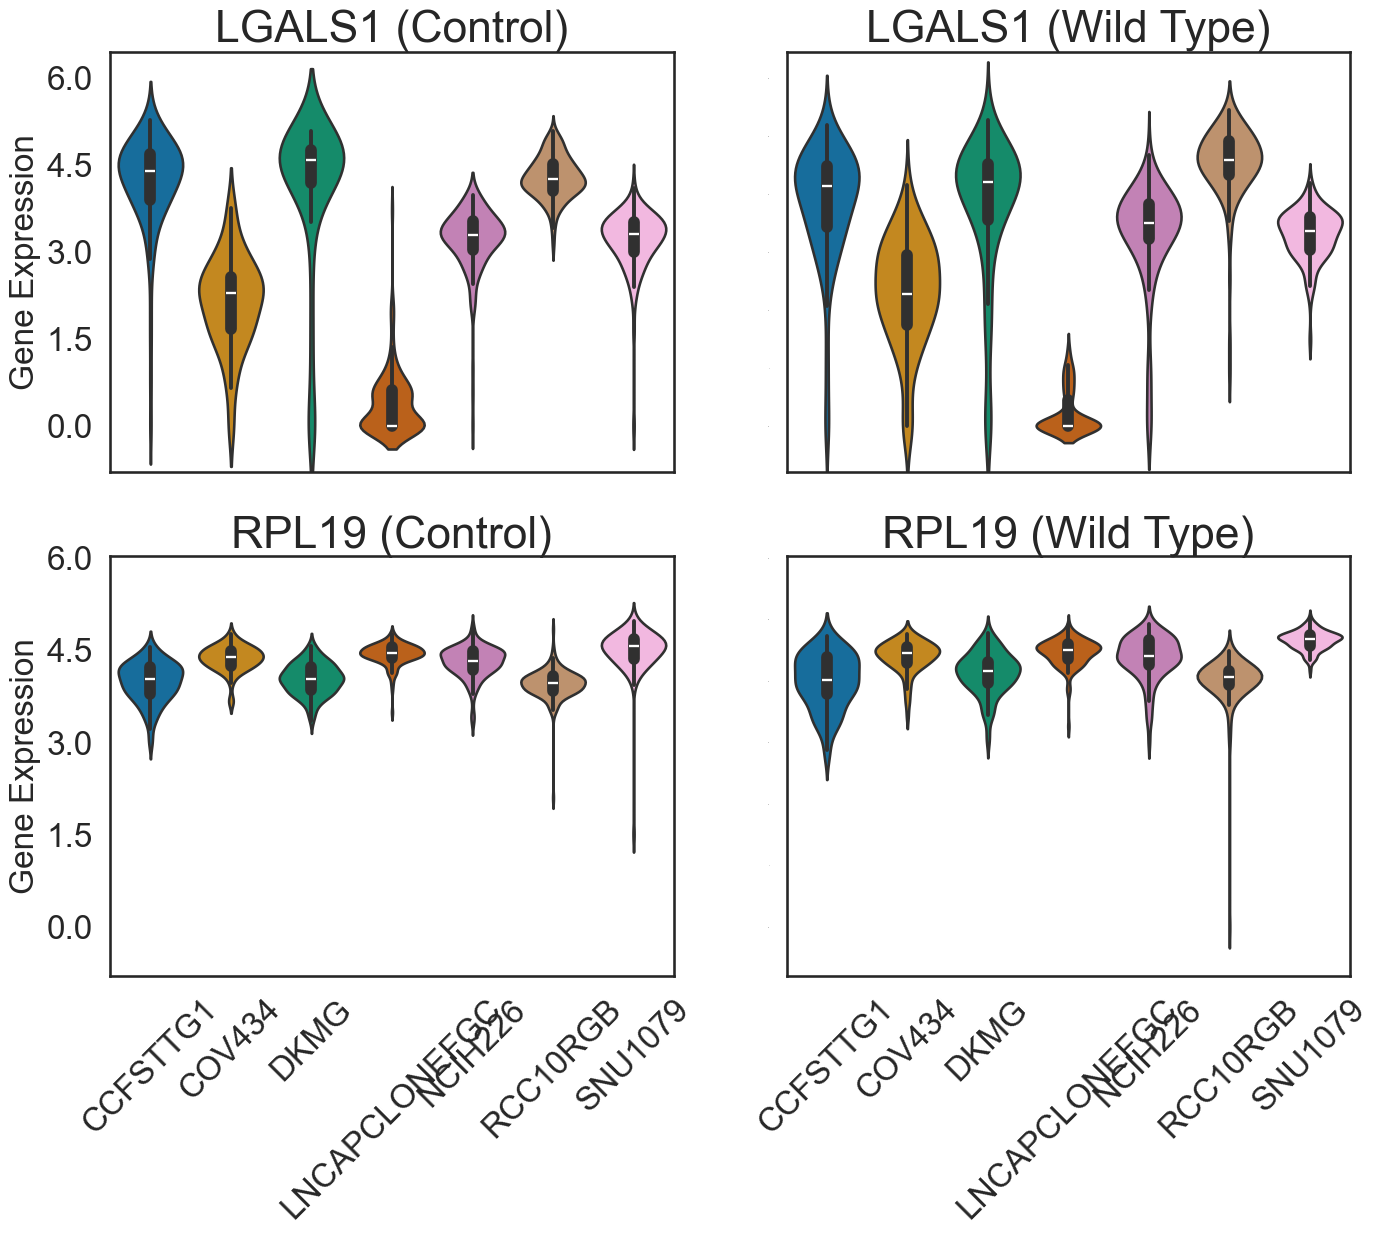

In [49]:
gene_indices = [cols_foreground[1], cols_foreground[3]]
gene_names = ["LGALS1", "RPL19"]

selected_cell_types = [
    'CCFSTTG1', 'COV434', 'DKMG',
    'LNCAPCLONEFGC', 'NCIH226',
    'RCC10RGB', 'SNU1079'
]

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'          
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values
cell_types_background_short = pd.Series(cell_types_background).map(cell_type_map).fillna(pd.Series(cell_types_background)).values

sns.set_theme(style="white", context="talk", palette="colorblind")
title_fontsize = 32
axis_label_fontsize = 24
tick_label_fontsize = 24
palette = sns.color_palette("colorblind", len(selected_cell_types))

fig, axes = plt.subplots(len(gene_indices), 2, figsize=(16, 6 * len(gene_indices)))
palette_dict = {cell_type: color for cell_type, color in zip(selected_cell_types, palette)}

for i, (gene_index, gene_name) in enumerate(zip(gene_indices, gene_names)):
    gene_expression_foreground = foreground.iloc[:, gene_index]
    gene_expression_background = background.iloc[:, gene_index]

    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground.values,
        'Cell Type': cell_types_short,
        'Group': labels 
    })

    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Cell Type': cell_types_background_short,
        'Group': ['Control'] * len(gene_expression_background)  
    })

    data_foreground_filtered = data_foreground[data_foreground['Cell Type'].isin(selected_cell_types)]
    data_background_filtered = data_background[data_background['Cell Type'].isin(selected_cell_types)]

    data_mutation_0 = data_foreground_filtered[data_foreground_filtered['Group'] == 0]

    y_min = min(
        data_foreground_filtered['Gene Expression'].min(),
        data_background_filtered['Gene Expression'].min()
    ) - 0.8
    y_max = max(
        data_foreground_filtered['Gene Expression'].max(),
        data_background_filtered['Gene Expression'].max()
    ) + 1


    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background_filtered,
        order=selected_cell_types, ax=axes[i, 0], hue='Cell Type', legend=False, palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=title_fontsize)
    axes[i, 0].set_ylim(y_min, y_max)  
    axes[i, 0].tick_params(axis='x', labelsize=0)  
    axes[i, 0].tick_params(axis='y', labelsize=tick_label_fontsize)

    axes[i, 0].set_ylabel("Gene Expression", fontsize=axis_label_fontsize)

    axes[i, 0].yaxis.set_major_locator(MaxNLocator(5)) 

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_mutation_0,
        order=selected_cell_types, ax=axes[i, 1], hue='Cell Type', legend=False, palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Wild Type)", fontsize=title_fontsize)
    axes[i, 1].set_ylim(y_min, y_max)  
    axes[i, 1].tick_params(axis='x', labelsize=0)  
    axes[i, 1].tick_params(axis='y', labelsize=0) 

    if len(selected_cell_types) > 3 and i == 2:  
        for col in range(2):
            tick_labels = axes[i, col].get_xticklabels()
            fourth_label = tick_labels[3]
            axes[i, col].text(
                2, y_min - 0.2, fourth_label.get_text(),
                fontsize=tick_label_fontsize, ha='center', va='top', rotation=45
            )
            fourth_label.set_visible(False)

for ax in axes[:-1, :]:  
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])

for ax in axes[-1, :]:  
    ax.set_xticks(range(len(selected_cell_types)))  
    ax.set_xticklabels(selected_cell_types, rotation=45, fontsize=tick_label_fontsize) 

for ax in axes[:, 1]:  
    ax.set_ylabel('')  

for ax in axes.flatten():
    ax.set_xlabel('')  
    
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules')
#plt.savefig('sm_cur_suppl.png', dpi=300, bbox_inches='tight')

plt.show()


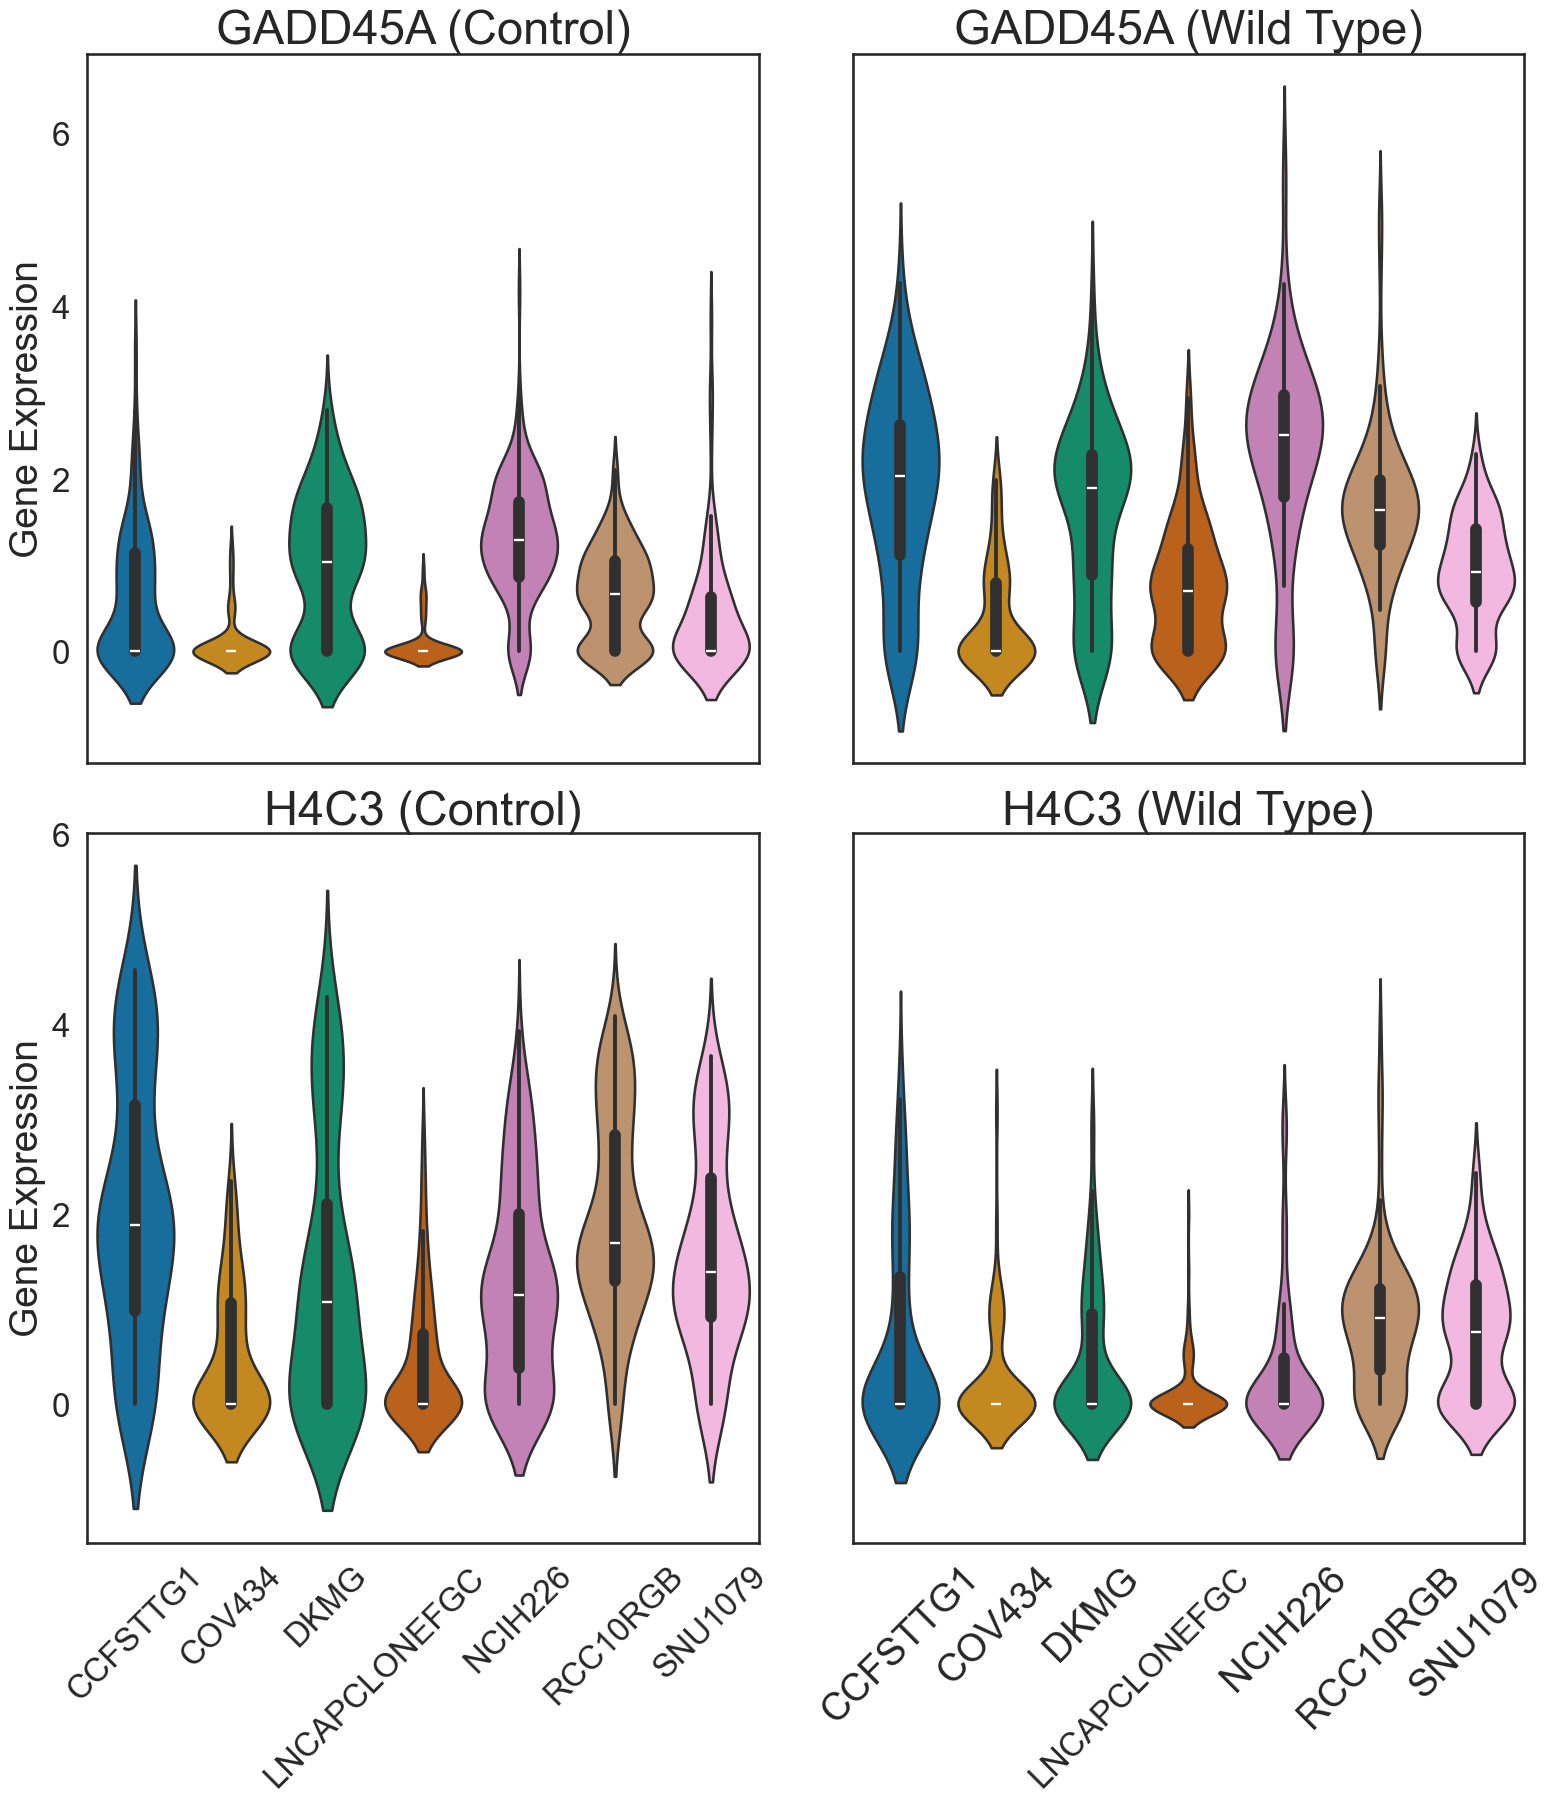

In [57]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gene_indices = [cpca_indices[0], cpca_indices[1]]
gene_names = ["GADD45A", "H4C3"]

selected_cell_types = [
    'CCFSTTG1', 'COV434', 'DKMG',
    'LNCAPCLONEFGC', 'NCIH226',
    'RCC10RGB', 'SNU1079'
]

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values
cell_types_background_short = pd.Series(cell_types_background).map(cell_type_map).fillna(pd.Series(cell_types_background)).values

sns.set_theme(style="white", context="talk", palette="colorblind")
palette = sns.color_palette("colorblind", len(selected_cell_types))

fig, axes = plt.subplots(len(gene_indices), 2, figsize=(16, 9 * len(gene_indices)), sharey='row')

for i, (gene_index, gene_name) in enumerate(zip(gene_indices, gene_names)):
    gene_expression_foreground = foreground.iloc[:, gene_index]
    gene_expression_background = background.iloc[:, gene_index]

    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground.values,
        'Cell Type': cell_types_short,
        'Group': labels
    })
    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Cell Type': cell_types_background_short,
        'Group': ['Control'] * len(gene_expression_background)
    })

    data_foreground_filtered = data_foreground[data_foreground['Cell Type'].isin(selected_cell_types)]
    data_background_filtered = data_background[data_background['Cell Type'].isin(selected_cell_types)]
    data_mutation_0 = data_foreground_filtered[data_foreground_filtered['Group'] == 0]

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background_filtered,
        order=selected_cell_types, ax=axes[i, 0], palette=palette, width=0.8
    )

    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=34)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=28)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=24)
    axes[i, 0].tick_params(axis='y', labelsize=24)  
    axes[i, 0].yaxis.set_major_locator(MaxNLocator(5))
    #axes[i, 0].set_yticks([0, 1, 2, 3])  
    axes[i, 0].set_xlabel("")  
    if i == 1:
        axes[i, 0].set_yticks([0, 2, 4, 6])
    if i == 0:
        axes[i, 0].set_xticklabels([])

    if len(selected_cell_types) > 3 and i > 0:  
        tick_labels_control = axes[i, 0].get_xticklabels()
        fourth_label_control = tick_labels_control[3]
        axes[i, 0].text(
            3 - 0.5, -4.1, fourth_label_control.get_text(),  
            fontsize=24, ha='center', va='bottom', rotation=45
        )
        fourth_label_control.set_visible(False)

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_mutation_0,
        order=selected_cell_types, ax=axes[i, 1], palette=palette, width=0.8
    )
    axes[i, 1].set_title(f"{gene_name} (Wild Type)", fontsize=34)
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=28)
    axes[i, 1].tick_params(axis='y', labelsize=0)  
    axes[i, 1].set_ylabel("")
    axes[i, 1].set_xlabel("")  

    if i == 0:
        axes[i, 1].set_xticklabels([])

    if len(selected_cell_types) > 3 and i > 0:  
        tick_labels_wild = axes[i, 1].get_xticklabels()
        fourth_label_wild = tick_labels_wild[3]
        axes[i, 1].text(
            3 - 0.5, -4.1, fourth_label_wild.get_text(),  
            fontsize=24, ha='center', va='bottom', rotation=45
        )
        fourth_label_wild.set_visible(False)

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.tight_layout()

os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules')
#plt.savefig('sm_cpca_suppl.png', dpi=300, bbox_inches='tight')

plt.show()


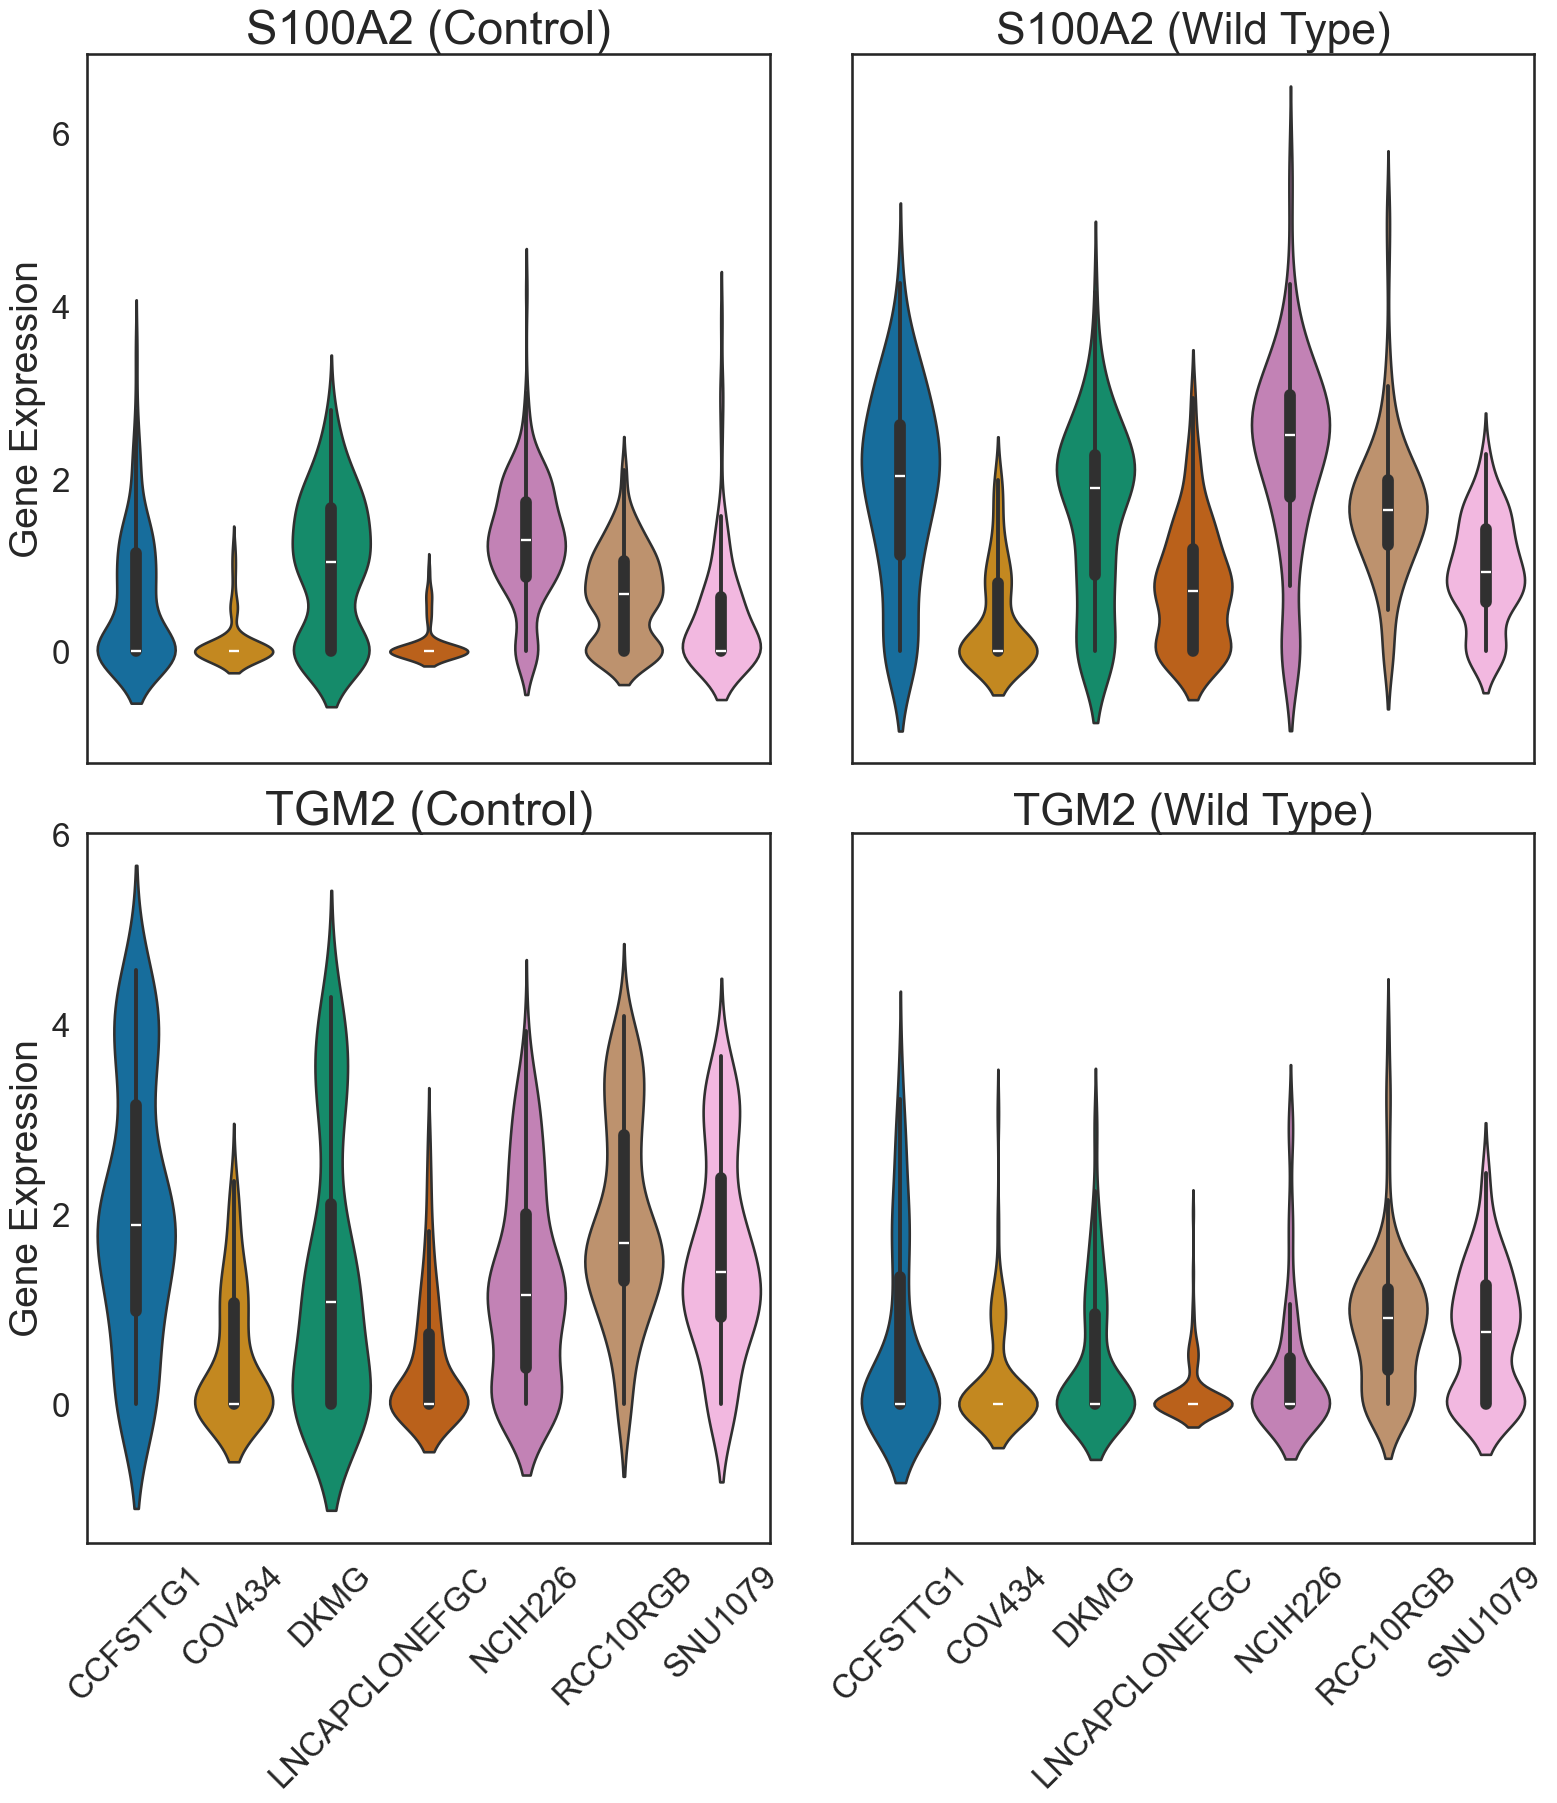

In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gene_index1 = foreground.columns.get_loc("ENSG00000196754")
gene_index2 = foreground.columns.get_loc("ENSG00000198959")

gene_indices = [cpca_indices[0], cpca_indices[1]]
gene_names = ["S100A2", "TGM2"]

selected_cell_types = [
    'CCFSTTG1', 'COV434', 'DKMG',
    'LNCAPCLONEFGC', 'NCIH226',
    'RCC10RGB', 'SNU1079'
]

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values
cell_types_background_short = pd.Series(cell_types_background).map(cell_type_map).fillna(pd.Series(cell_types_background)).values

sns.set_theme(style="white", context="talk", palette="colorblind")
palette = sns.color_palette("colorblind", len(selected_cell_types))

fig, axes = plt.subplots(len(gene_indices), 2, figsize=(16, 9 * len(gene_indices)), sharey='row')

for i, (gene_index, gene_name) in enumerate(zip(gene_indices, gene_names)):
    gene_expression_foreground = foreground.iloc[:, gene_index]
    gene_expression_background = background.iloc[:, gene_index]

    data_foreground = pd.DataFrame({
        'Gene Expression': gene_expression_foreground.values,
        'Cell Type': cell_types_short,
        'Group': labels
    })
    data_background = pd.DataFrame({
        'Gene Expression': gene_expression_background,
        'Cell Type': cell_types_background_short,
        'Group': ['Control'] * len(gene_expression_background)
    })

    data_foreground_filtered = data_foreground[data_foreground['Cell Type'].isin(selected_cell_types)]
    data_background_filtered = data_background[data_background['Cell Type'].isin(selected_cell_types)]
    data_mutation_0 = data_foreground_filtered[data_foreground_filtered['Group'] == 0]

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background_filtered,
        order=selected_cell_types, ax=axes[i, 0], palette=palette, width=0.8
    )

    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=34)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=28)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=24)
    axes[i, 0].tick_params(axis='y', labelsize=24)  
    axes[i, 0].yaxis.set_major_locator(MaxNLocator(5))
    #axes[i, 0].set_yticks([0, 1, 2, 3])  
    axes[i, 0].set_xlabel("")  
    if i == 1:
        axes[i, 0].set_yticks([0, 2, 4, 6])
    if i == 0:
        axes[i, 0].set_xticklabels([])

    if len(selected_cell_types) > 3 and i > 0:  
        tick_labels_control = axes[i, 0].get_xticklabels()
        fourth_label_control = tick_labels_control[3]
        axes[i, 0].text(
            3 - 0.5, -4.1, fourth_label_control.get_text(),  
            fontsize=24, ha='center', va='bottom', rotation=45
        )
        fourth_label_control.set_visible(False)

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_mutation_0,
        order=selected_cell_types, ax=axes[i, 1], palette=palette, width=0.8
    )
    axes[i, 1].set_title(f"{gene_name} (Wild Type)", fontsize=32)
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=24)
    axes[i, 1].tick_params(axis='y', labelsize=0)  
    axes[i, 1].set_ylabel("")
    axes[i, 1].set_xlabel("")  

    if i == 0:
        axes[i, 1].set_xticklabels([])

    if len(selected_cell_types) > 3 and i > 0:  
        tick_labels_wild = axes[i, 1].get_xticklabels()
        fourth_label_wild = tick_labels_wild[3]
        axes[i, 1].text(
            3 - 0.5, -4.1, fourth_label_wild.get_text(),  
            fontsize=24, ha='center', va='bottom', rotation=45
        )
        fourth_label_wild.set_visible(False)

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.tight_layout()

os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Small Molecules')
#plt.savefig('sm_cfs_suppl.png', dpi=300, bbox_inches='tight')

plt.show()
